# Comparison between "Comprehensive upper-air observation network from 1905 to present" and "Insitu IGRA radiosoundings baseline network"

**Contains modified Copernicus Climate Change Service Information 2020**
under [License](https://apps.ecmwf.int/datasets/licences/copernicus/)

*Copernicus Climate Change Service (C3S) - Upper Air Data Service (2020)*

The purpose of this IPython Notebook is to find differences in both mentioned data sets and to compare them. 

    Author: U. Voggenberger
    Date: 02.2021
    Contact: ulrich.voggenberger [at] univie.ac.at
    License: C3S, 2021


In [9]:
import os, sys
euapath = os.getcwd()+'/../cds-backend/code/'
sys.path.append(euapath)
try:
    import cds_eua3 as eua
except:
    print('could not import eua')
    print('please download https://github.com/MBlaschek/CEUAS/blob/master/CEUAS/public/cds-backend/code/cds_eua3.py and save in ', euapath)
    print('or get the whole repository from https://github.com/MBlaschek/CEUAS')

In [10]:
import pandas
import numpy as np
import sys, zipfile, os, time
import matplotlib.pyplot as plt
import glob
import datetime
import urllib3
import cdsapi
import xarray
import shutil
import warnings
import pickle
warnings.filterwarnings('ignore')


In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 10),
         'axes.labelsize': 20,
         'axes.titlesize': 24,
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

In [3]:
def request(rqdict, source, remove_file=False):
    t0 = time.time()

    c = cdsapi.Client()
    r = c.retrieve(
        source,rqdict)
    if True:
        r.download(target='download.zip')
        assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./download/')
    z.close()
    print('Request took: ' + str(time.time() - t0) + ' seconds')
    
    files = glob.glob('./download/*.nc')
    
    if files[0].split('/')[-1].startswith('IGRA'):
        ds = xarray.open_dataset(files[0])            
        data = ds.to_dataframe()
        for i in files[1:]:
            ds = xarray.open_dataset(i)            
            data = data.append(ds.to_dataframe())

    else:
        ds = xarray.open_dataset(files[0], decode_cf=True) 
        to_be_removed = ['station_id', 'report_id', 'trajectory_index', 'trajectory_label']
        strings_toremove = ['trajectory']
        for i in ds.dims:
            if i.startswith('string'):
                strings_toremove.append(i)
        try:
            ds = ds.drop_vars(to_be_removed)
        except:
            pass
        try:
            ds = ds.drop(strings_toremove)
        except:
            pass
        data = ds.to_dataframe()
        for i in files[1:]:
            strings_toremove = ['trajectory']
            ds = xarray.open_dataset(i)  
            for i in ds.dims:
                if i.startswith('string'):
                    strings_toremove.append(i)
            try:
                ds = ds.drop_vars(to_be_removed)
            except:
                pass
            try:
                ds = ds.drop(strings_toremove)
            except:
                pass
            data = data.append(ds.to_dataframe())
            
    os.remove('download.zip')
    if remove_file:
        try:
           shutil.rmtree('./download/')
        except:
           print('Error while deleting directory')

    return data

In [4]:
def points(lon, lat, labels=None, values=None, markersize=80, ocean=True, land=True, coastlines=True, rivers=False,
           grid=True, posneg=False, extent=None, lloffset=0.2, showcost=False, clabel=None, cbars={}, colorlevels=None,
           data=None, vmin=None, vmax=None, dropna=False, figure=None, gridspecs=None, showalpha=1, showtitle=' ', **kwargs):
    """ Plot stations on a map

    Args:
        lon (np.array, list): Longitudes
        lat (np.array, list): Latidutes
        labels (np.array, list): Labels
        values (np.array, list): Values for scatterplot
        markersize (int): markersize
        ocean (bool): plot ocean ?
        land (bool): plot land ?
        coastlines (bool): plot coastlines ?
        rivers (bool): plot river ?
        grid (bool): plot gridlines ?
        posneg (bool): different markers for positive and negative
        extent (str): neither (default), both, min, max
        lloffset (float): label offset
        showcost (bool): Estimate Cost function and add to title
        clabel (str): Colorbar Label
        cbars (dict): Colorbar Options
        colorlevels (list, str): scatterplot colorlevels
        data (xr.DataArray): Data
        vmin (float): minimum value
        vmax (float): maximum value
        dropna (bool): Remove missing values?
        figure (plt.figure): figure handle
        gridspecs (dict): gridspec options for figure
        **kwargs:

    Returns:
        plt.axes
    """
    import numpy as np
    import cartopy as cpy
    from matplotlib.colors import BoundaryNorm
    import matplotlib.pyplot as plt
#     from ._helpers import cost, plot_arange as pa, plot_levels as pl

    if data is not None:
        lon = data[lon]
        lat = data[lat]
        values = data

    lon = np.asarray(lon)
    lat = np.asarray(lat)

    if lon.size != lat.size:
        raise ValueError("Lon and Lat need same size")

    if values is not None:
        values = np.asarray(values, dtype=float)
        nn = np.size(values)
        if lon.size != lat.size or lon.size != values.size:
            raise ValueError("Lon, Lat and Values need same size", lon.size, lat.size, values.size)

        if vmin is not None:
            idx = values < vmin
            values[idx] = np.nan
            print("vmin", idx.sum(), nn)

        if vmax is not None:
            idx = values > vmax
            values[idx] = np.nan
            print("vmax", idx.sum(), nn)

        if dropna:
            idx = np.isfinite(values)
            values = values[idx]
            lon = lon[idx]
            lat = lat[idx]
            print("NA", nn - idx.sum(), nn)

    projection = kwargs.get('projection', cpy.crs.PlateCarree())
    if figure is None:
        ax = plt.axes(projection=projection)
    else:
        ax = figure.add_subplot(gridspecs, projection=projection)

    if ocean:
        ax.add_feature(cpy.feature.OCEAN, zorder=0, facecolor=kwargs.get('ocean_facecolor', cpy.feature.COLORS['water']))

    if land:
        ax.add_feature(cpy.feature.LAND, zorder=0, facecolor=kwargs.get('land_facecolor', cpy.feature.COLORS['land']))

    if coastlines:
        ax.coastlines()

    if rivers:
        ax.add_feature(cpy.feature.LAKES, zorder=0)
        ax.add_feature(cpy.feature.RIVERS, zorder=1)

    if labels is not None:
        labels = np.asarray(labels)

    if values is None:
        ax.scatter(lon, lat, s=markersize,alpha=showalpha, c=kwargs.get('color', 'r'), transform=cpy.crs.PlateCarree(), zorder=10,
                   edgecolor='k')  # ontop
    else:
        if posneg:
            kwargs['marker'] = np.where(values < 0, 'd', 'o')

        cmap = plt.get_cmap(kwargs.pop('cmap', None))
        norm = None
        if colorlevels is not None:
            if isinstance(colorlevels, str):
                colorlevels = eval(colorlevels)  # plot_levels, plot_arange

            norm = BoundaryNorm(colorlevels, cmap.N)
        idx = np.isfinite(values)
        cs = ax.scatter(lon[idx], lat[idx], s=markersize, c=values[idx],
                        transform=cpy.crs.PlateCarree(),
                        zorder=10,
                        cmap=cmap,
                        edgecolor='k',
                        alpha=showalpha,
                        marker=kwargs.get('marker', 'o'),
                        norm=norm)

        cbars['fraction'] = cbars.get('fraction', 0.01)
        cbars['aspect'] = cbars.get('aspect', 50)
        cbars['shrink'] = cbars.get('shrink', 0.8)
        cbars['extend'] = cbars.get('extend', 'both')
        cb = plt.colorbar(cs, ax=ax, **cbars)

        if clabel is not None:
            cb.set_label(clabel)

        if showcost:
            tcost = cost(lon, lat, values)

        if np.isfinite(values).sum() != np.size(values):
            itx = ~np.isfinite(values)
            ax.scatter(lon[itx], lat[itx], s=markersize, marker='s', c='w', transform=cpy.crs.PlateCarree(), zorder=9,
                       edgecolor='k',alpha=showalpha)

    if labels is not None:
        if not hasattr(lloffset, '__iter__'):
            lloffset = [lloffset] * len(labels)

        for i, j, l, k in zip(lon, lat, labels, lloffset):
            ax.text(i + k, j, str(l), horizontalalignment='left', verticalalignment='top',
                    transform=cpy.crs.PlateCarree(), fontsize=kwargs.get('fontsize', 8), zorder=12,
                    clip_on=True)

    if grid:
        try:
            gl = ax.gridlines(draw_labels=True, xlocs=kwargs.get('xlocs', None), ylocs=kwargs.get('ylocs', None),
                              linewidth=0.5, linestyle='--', color='k')
            gl.xformatter = cpy.mpl.gridliner.LONGITUDE_FORMATTER
            gl.yformatter = cpy.mpl.gridliner.LATITUDE_FORMATTER
            gl.xlabels_top = False
            gl.ylabels_right = False
        except:
            ax.gridlines(draw_labels=False)

    if values is not None:
        nn = np.sum(np.isfinite(values))
        title = showtitle
        # COST Summary
        if showcost:
            tscost = np.nansum(tcost) / np.sum(np.isfinite(values))
            title += ' Cost: %5.2f' % tscost
    else:
        title = 'Stations # %d' % np.size(lon)

    ax.set_title(kwargs.get('title', '') + ' ' + title)

    if 'xlabel' in kwargs.keys():
        ax.set_xlabel(kwargs.get('xlabel'))

    if 'ylabel' in kwargs.keys():
        ax.set_ylabel(kwargs.get('ylabel'))

    if extent is not None:
        ax.set_extent(extent, crs=cpy.crs.PlateCarree())

    return ax

---

# Comparing available stations for IGRA (and its harmonized version) and Comprehensive upper-air observation network (CUON)

---

In [5]:
cuon = 'insitu-comprehensive-upper-air-observation-network'
igra = 'insitu-observations-igra-baseline-network'

## Requesting the global data and checking for the number of different stations


In [6]:
dates = ['1980-01-01/1980-01-02','1990-01-01/1990-01-02','2000-01-01/2000-01-02','2010-01-01/2010-01-02','2020-01-01/2020-01-02']   
statscuon = []
statsigra = []
statsigrah = []
for i in dates:
    print('date range: ' + i)
    da_c = request({
        'variable': 'temperature',
        'period': i,
    }, cuon, remove_file=True)
    x = len(da_c.drop_duplicates(['lat', 'lon']))
    statscuon.append(x)
    print('requestable stations from CUON: ' + str(x))

    da_i = request({
        'source': 'IGRA',
        'variable': ['air_temperature'],
        'period': i,
    }, igra, remove_file=True)
    x = len(da_i.drop_duplicates(['latitude', 'longitude']))
    print('requestable stations from IGRA: ' + str(x))
    statsigra.append(x)
    da_ih = request({
        'source': 'IGRA_H',
        'variable': ['air_temperature'],
        'period': i,
    }, igra, remove_file=True)
    x = len(da_ih.drop_duplicates(['latitude', 'longitude']))
    print('requestable stations from IGRA_H: ' + str(x))
    statsigrah.append(x)
    print('\n')

2021-06-21 15:34:37,890 INFO Welcome to the CDS
2021-06-21 15:34:37,891 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


date range: 1980-01-01/1980-01-02


2021-06-21 15:34:38,139 INFO Request is completed
2021-06-21 15:34:38,141 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1624282041.2509727-17193-7-4f1ac952-68fd-4768-a8de-70071972bc76.zip to download.zip (31.5M)
2021-06-21 15:34:42,649 INFO Download rate 7M/s     


Request took: 6.95183539390564 seconds


2021-06-21 15:35:06,954 INFO Welcome to the CDS
2021-06-21 15:35:06,955 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network


requestable stations from CUON: 957


2021-06-21 15:35:07,108 INFO Request is completed
2021-06-21 15:35:07,110 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.insitu_reference.retrieve-1624282079.2651167-17193-8-c51aca66-58d8-428e-a967-883de0c55d5c.zip to download.zip (190.5K)
2021-06-21 15:35:07,309 INFO Download rate 958.1K/s


Request took: 0.6425366401672363 seconds
Error while deleting directory
requestable stations from IGRA: 645


2021-06-21 15:35:07,684 INFO Welcome to the CDS
2021-06-21 15:35:07,685 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2021-06-21 15:35:07,828 INFO Request is completed
2021-06-21 15:35:07,830 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.insitu_reference.retrieve-1624282084.2579813-17195-7-c4112028-c328-46bd-9692-d1417d5a6e5b.zip to download.zip (145.3K)
2021-06-21 15:35:08,011 INFO Download rate 808.9K/s


Request took: 0.5034341812133789 seconds
Error while deleting directory
requestable stations from IGRA_H: 337


date range: 1990-01-01/1990-01-02


2021-06-21 15:35:08,278 INFO Welcome to the CDS
2021-06-21 15:35:08,279 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-06-21 15:35:08,442 INFO Request is completed
2021-06-21 15:35:08,444 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1624282104.4571311-17195-8-0c1dc321-29f8-4ce0-967d-4bd1cbd41636.zip to download.zip (31.2M)
2021-06-21 15:35:13,685 INFO Download rate 6M/s     


Request took: 7.490936517715454 seconds


2021-06-21 15:35:36,923 INFO Welcome to the CDS
2021-06-21 15:35:36,924 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network


requestable stations from CUON: 968


2021-06-21 15:35:37,077 INFO Request is completed
2021-06-21 15:35:37,078 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.insitu_reference.retrieve-1624282136.5985713-17197-7-238d715a-ff21-4c2e-9a24-12f49a1f90e0.zip to download.zip (184.5K)
2021-06-21 15:35:37,257 INFO Download rate 1M/s   


Request took: 0.4941279888153076 seconds
Error while deleting directory
requestable stations from IGRA: 521


2021-06-21 15:35:37,517 INFO Welcome to the CDS
2021-06-21 15:35:37,518 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2021-06-21 15:35:37,662 INFO Request is completed
2021-06-21 15:35:37,663 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.insitu_reference.retrieve-1624282139.506414-17259-6-6c98f302-a64b-4b36-9add-3442c00e7bfb.zip to download.zip (136.9K)
2021-06-21 15:35:37,833 INFO Download rate 812.6K/s


Request took: 0.468904972076416 seconds
Error while deleting directory
requestable stations from IGRA_H: 263


date range: 2000-01-01/2000-01-02


2021-06-21 15:35:38,086 INFO Welcome to the CDS
2021-06-21 15:35:38,087 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-06-21 15:35:38,260 INFO Request is completed
2021-06-21 15:35:38,262 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1624282147.2713115-17197-8-249e20fb-c742-4532-b47d-7e7713009e47.zip to download.zip (25.4M)
2021-06-21 15:35:42,073 INFO Download rate 6.7M/s   


Request took: 5.978587627410889 seconds
requestable stations from CUON: 742


2021-06-21 15:35:59,537 INFO Welcome to the CDS
2021-06-21 15:35:59,542 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2021-06-21 15:35:59,731 INFO Request is completed
2021-06-21 15:35:59,734 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.insitu_reference.retrieve-1624282172.902969-19602-6-41e43352-310b-4dff-804d-ed505403810e.zip to download.zip (322.1K)
2021-06-21 15:36:00,002 INFO Download rate 1.2M/s 


Request took: 0.7459383010864258 seconds
Error while deleting directory
requestable stations from IGRA: 549


2021-06-21 15:36:00,401 INFO Welcome to the CDS
2021-06-21 15:36:00,404 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2021-06-21 15:36:00,564 INFO Request is completed
2021-06-21 15:36:00,566 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.insitu_reference.retrieve-1624282175.3801854-19624-5-4b8b3484-94a9-47e6-9f07-cb0146cead7c.zip to download.zip (355.7K)
2021-06-21 15:36:00,821 INFO Download rate 1.4M/s 


Request took: 0.6134693622589111 seconds
Error while deleting directory
requestable stations from IGRA_H: 391


date range: 2010-01-01/2010-01-02


2021-06-21 15:36:01,159 INFO Welcome to the CDS
2021-06-21 15:36:01,161 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-06-21 15:36:01,334 INFO Request is completed
2021-06-21 15:36:01,336 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1624282190.95636-17259-7-b06d6617-5ed9-4c44-bed1-572080f5142b.zip to download.zip (27.8M)
2021-06-21 15:36:04,836 INFO Download rate 8M/s     


Request took: 5.382137298583984 seconds


2021-06-21 15:36:25,058 INFO Welcome to the CDS
2021-06-21 15:36:25,060 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network


requestable stations from CUON: 777


2021-06-21 15:36:25,213 INFO Request is completed
2021-06-21 15:36:25,214 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.insitu_reference.retrieve-1624282225.5436318-20428-5-d94efad0-2de7-4f3f-8fd0-50bb767ce945.zip to download.zip (430.5K)
2021-06-21 15:36:25,467 INFO Download rate 1.7M/s 


Request took: 0.606088399887085 seconds
Error while deleting directory
requestable stations from IGRA: 632


2021-06-21 15:36:25,825 INFO Welcome to the CDS
2021-06-21 15:36:25,826 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2021-06-21 15:36:25,970 INFO Request is completed
2021-06-21 15:36:25,973 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.insitu_reference.retrieve-1624282229.5752864-20506-5-1988bc91-72fd-4c5f-b21f-69a1fd0eed47.zip to download.zip (450.5K)
2021-06-21 15:36:26,263 INFO Download rate 1.5M/s 


Request took: 0.6263427734375 seconds
Error while deleting directory
requestable stations from IGRA_H: 462


date range: 2020-01-01/2020-01-02


2021-06-21 15:36:26,632 INFO Welcome to the CDS
2021-06-21 15:36:26,633 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-06-21 15:36:26,801 INFO Request is completed
2021-06-21 15:36:26,803 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1624282250.2763486-19602-7-d2f08368-b406-4423-8069-5f63f5896c5b.zip to download.zip (112.4M)
2021-06-21 15:36:41,178 INFO Download rate 7.8M/s  


Request took: 17.322014808654785 seconds


2021-06-21 15:37:14,807 INFO Welcome to the CDS
2021-06-21 15:37:14,808 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network


requestable stations from CUON: 904


2021-06-21 15:37:15,071 INFO Request is completed
2021-06-21 15:37:15,072 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.insitu_reference.retrieve-1624282297.194231-10007-5-4bb78c41-d9a1-4e71-8356-d280edf0c561.zip to download.zip (533.8K)
2021-06-21 15:37:15,387 INFO Download rate 1.7M/s 


Request took: 0.857435941696167 seconds
Error while deleting directory
requestable stations from IGRA: 632


2021-06-21 15:37:15,808 INFO Welcome to the CDS
2021-06-21 15:37:15,809 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2021-06-21 15:37:15,949 INFO Request is completed
2021-06-21 15:37:15,950 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.insitu_reference.retrieve-1624282300.888593-12699-4-7c24ef77-80bb-4ea6-a12a-08f69e25620c.zip to download.zip (386.7K)
2021-06-21 15:37:16,209 INFO Download rate 1.5M/s 


Request took: 0.5804569721221924 seconds
Error while deleting directory
requestable stations from IGRA_H: 454




In [7]:
statscuon

[957, 968, 742, 777, 904]

2021-06-21 15:37:16,605 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-06-21 15:37:16,608 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-06-21 15:37:16,617 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-06-21 15:37:16,626 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


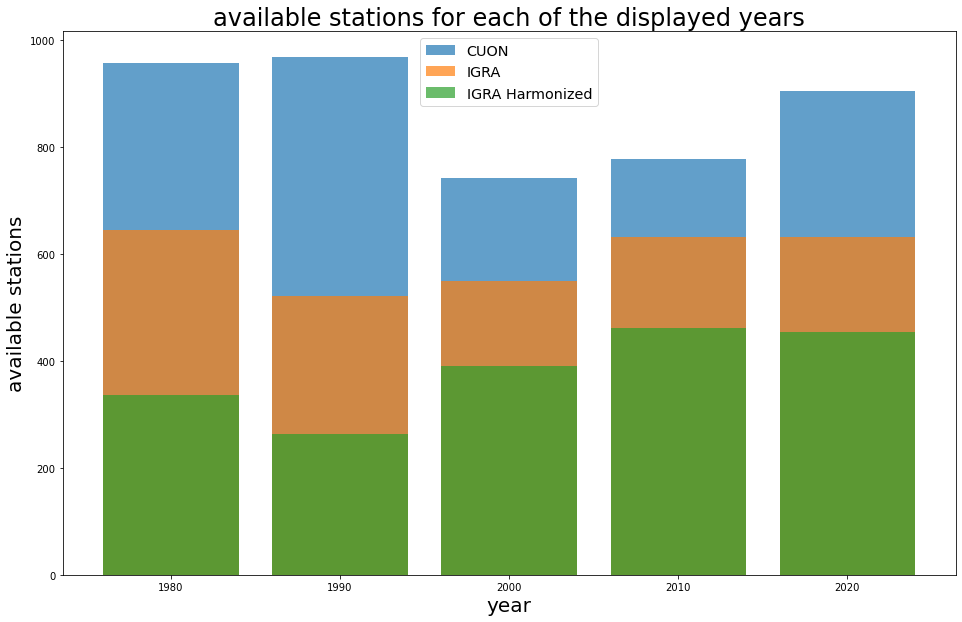

In [8]:
decades = ['1980', '1990', '2000', '2010','2020']

fig, (ax1) = plt.subplots(1, 1)

ax1.bar(decades, statscuon, label='CUON', alpha=0.7)
ax1.bar(decades, statsigra, label='IGRA', alpha=0.7)
ax1.bar(decades, statsigrah, label='IGRA Harmonized', alpha=0.7)

ax1.set(xlabel ='year', ylabel='available stations', title='available stations for each of the displayed years')
ax1.legend( loc='best')
plt.show()
plt.close(fig)

## Requesting the global data and checking for the number of available messurements per station


In [9]:
# decades = ['1980-01-01/1989-12-31','1990-01-01/1999-12-31','2000-01-01/2009-12-31','2010-01-01/2019-12-31']   
# decnames = ['1980s','1990s','2000s','2010s'] 

### IGRA

In [10]:
# for i in range(len(decades)):
#     da_ih = request({
#             'source': 'IGRA_H',
#             'variable': ['air_temperature'],
#             'period': decades[i],
#         }, igra)
#     with open('IGRAH_'+decnames[i]+'.p', 'wb') as handle:
#         pickle.dump(da_ih, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('IGRAH_01_2000s.p', 'rb') as handle:
#     b = pickle.load(handle)
# with open('IGRAH_02_2000s.p', 'rb') as handle:
#     a = pickle.load(handle)
# b=b.append(a)

# # with open('IGRAH_1980s.p', 'rb') as handle:
# #     b = pickle.load(handle)
    
# b=b.append(a)

# b = b[b.air_pressure == 50000]
# b

# b = b.dropna(axis=0, how='any')
# b

# out = pandas.DataFrame(columns=['lat', 'lon', 'obs'])
# for i in b.drop_duplicates('station_name')['station_name']:
#     check = b[b.station_name == i]
#     out = out.append({'lat': check.iloc[0].latitude, 'lon': check.iloc[0].longitude, 'obs': len(check)}, ignore_index=True)
# with open('/raid60/scratch/uli/igrah_500hpa_2000s.p', 'wb') as handle:
#     pickle.dump(out, handle, protocol=pickle.HIGHEST_PROTOCOL)

### CUON

In [40]:
i = glob.glob('/raid60/scratch/uli/ig*500*.p')
print(i)
c = glob.glob('/raid60/scratch/uli/cuon_n*500*.p')
print(c)

['/raid60/scratch/uli/igrah_500hpa_1980s.p', '/raid60/scratch/uli/igrah_500hpa_1990s.p', '/raid60/scratch/uli/igrah_500hpa_2010s.p', '/raid60/scratch/uli/igrah_500hpa_2000s.p']
['/raid60/scratch/uli/cuon_new_500hpa_2010s.p', '/raid60/scratch/uli/cuon_new_500hpa_1980s.p', '/raid60/scratch/uli/cuon_new_500hpa_1990s.p', '/raid60/scratch/uli/cuon_new_500hpa_2000s.p']


/raid60/scratch/uli/igrah_500hpa_1980s.p


<GeoAxesSubplot:title={'center':' igrah_500hpa_1980s'}>

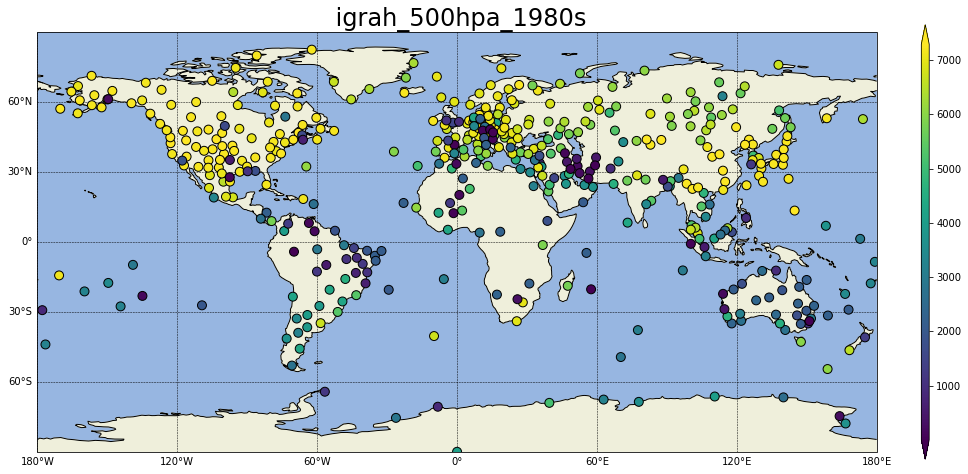

In [48]:
with open(i[0], 'rb') as handle:
    a = pickle.load(handle)
    print(i[0])
points(lon=a.lon, lat=a.lat, values=a.obs, showtitle=i[0].split('/')[-1][:-2])

/raid60/scratch/uli/cuon_new_500hpa_1980s.p


<GeoAxesSubplot:title={'center':' cuon_new_500hpa_1980s'}>

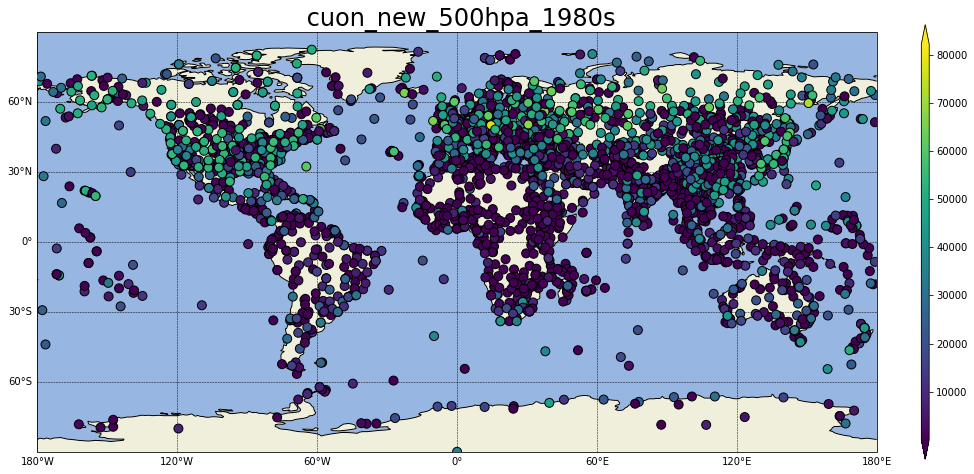

In [49]:
with open(c[1], 'rb') as handle:
    b = pickle.load(handle)
    print(c[1])
points(lon=b.lon, lat=b.lat, values=b.obs, showtitle=c[1].split('/')[-1][:-2])

<GeoAxesSubplot:title={'center':' cuon_new_500hpa_1980s -> 1 (yellow)\nigrah_500hpa_1980s -> 0 (purple)'}>

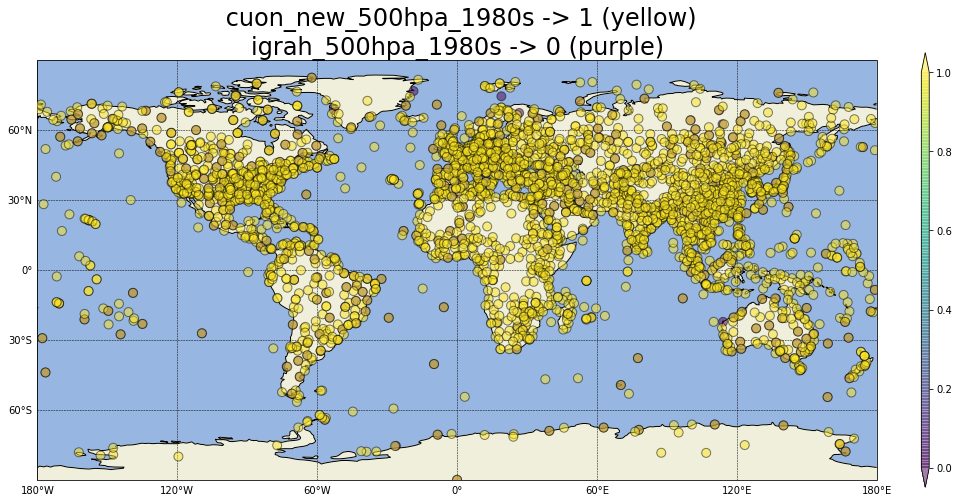

In [50]:
a['obs'].values[:] = 0
compare_i = a
b['obs'].values[:] = 1
compare_c = b
compare = pandas.DataFrame.append(compare_i, compare_c)
points(lon=compare.lon, lat=compare.lat, values=compare.obs, showalpha=0.5, showtitle=c[1].split('/')[-1][:-2] + ' -> 1 (yellow)'+ '\n' + i[0].split('/')[-1][:-2] +' -> 0 (purple)')

/raid60/scratch/uli/igrah_500hpa_1990s.p


<GeoAxesSubplot:title={'center':' igrah_500hpa_1990s'}>

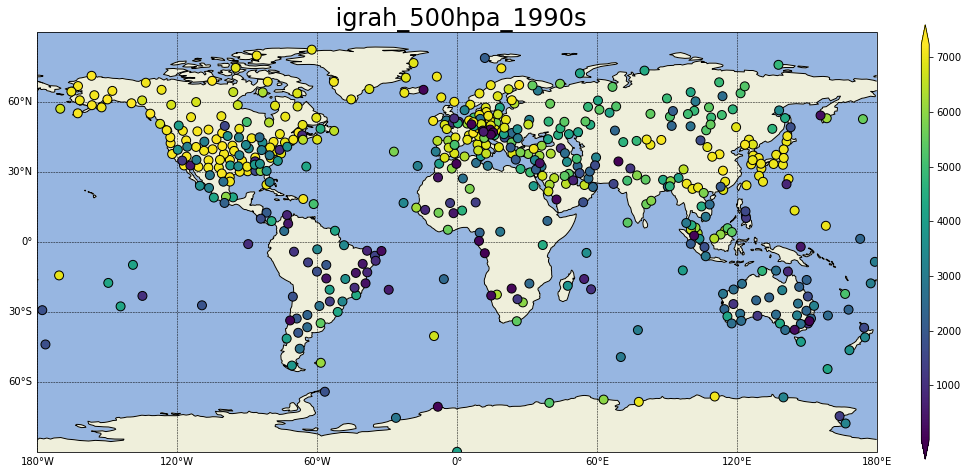

In [51]:
with open(i[1], 'rb') as handle:
    a = pickle.load(handle)
    print(i[1])
points(lon=a.lon, lat=a.lat, values=a.obs, showtitle=i[1].split('/')[-1][:-2])

/raid60/scratch/uli/cuon_new_500hpa_1990s.p


<GeoAxesSubplot:title={'center':' cuon_new_500hpa_1990s'}>

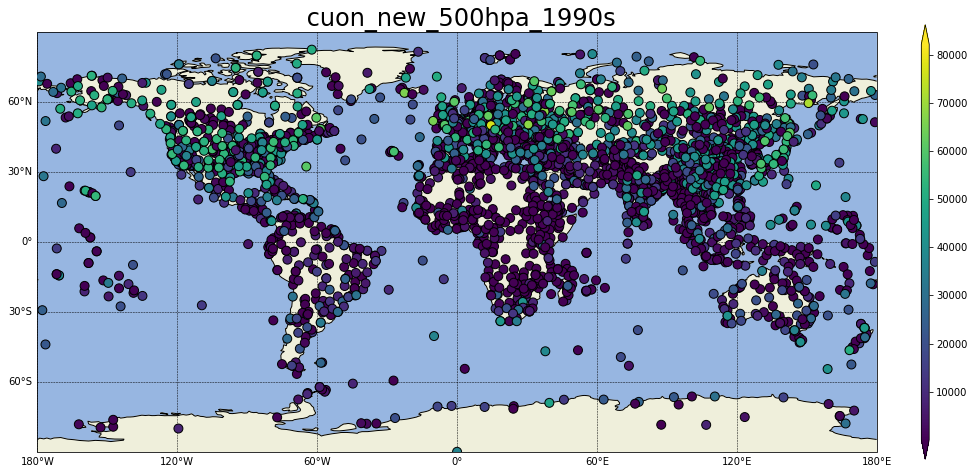

In [52]:
with open(c[2], 'rb') as handle:
    b = pickle.load(handle)
    print(c[2])
points(lon=b.lon, lat=b.lat, values=b.obs, showtitle=c[2].split('/')[-1][:-2])

<GeoAxesSubplot:title={'center':' cuon_new_500hpa_1990s -> 1 (yellow)\nigrah_500hpa_1990s -> 0 (purple)'}>

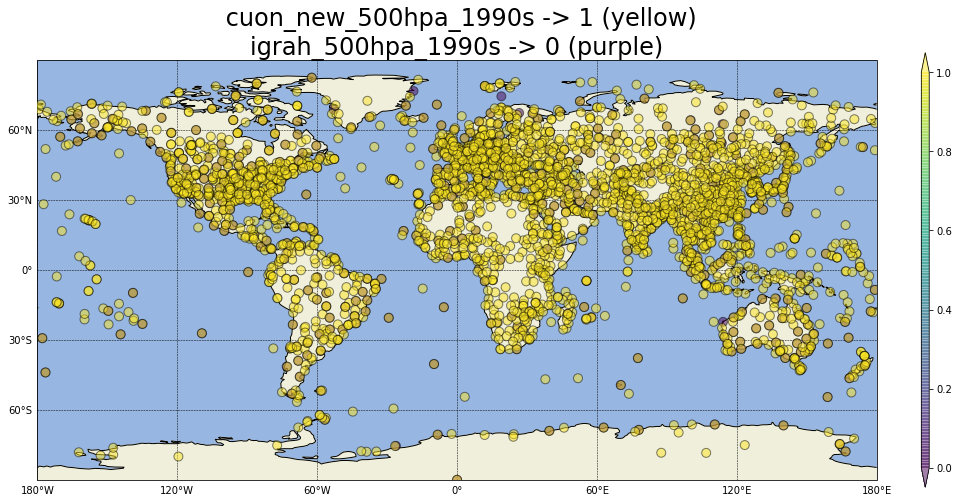

In [53]:
a['obs'].values[:] = 0
compare_i = a
b['obs'].values[:] = 1
compare_c = b
compare = pandas.DataFrame.append(compare_i, compare_c)
points(lon=compare.lon, lat=compare.lat, values=compare.obs, showalpha=0.5, showtitle=c[2].split('/')[-1][:-2] + ' -> 1 (yellow)'+ '\n' + i[1].split('/')[-1][:-2] +' -> 0 (purple)')

/raid60/scratch/uli/igrah_500hpa_2010s.p


<GeoAxesSubplot:title={'center':' igrah_500hpa_2000s'}>

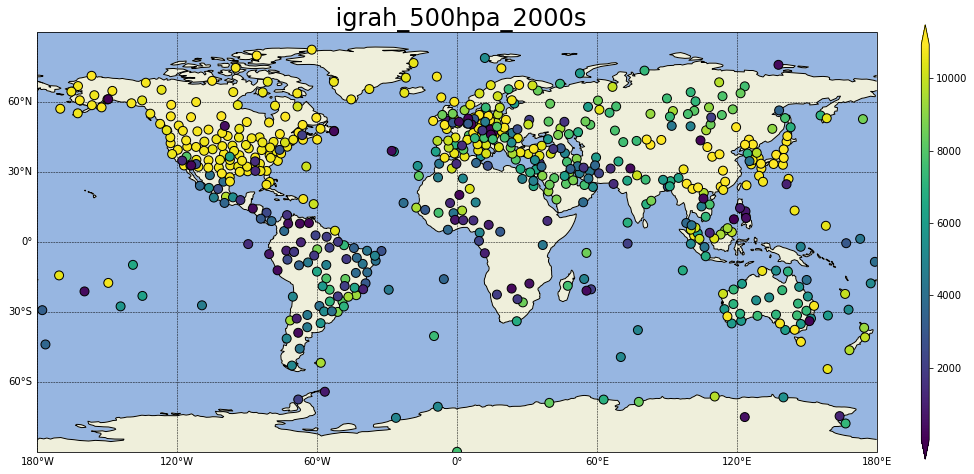

In [55]:
with open(i[3], 'rb') as handle:
    a = pickle.load(handle)
    print(i[2])
points(lon=a.lon, lat=a.lat, values=a.obs, showtitle=i[3].split('/')[-1][:-2])

/raid60/scratch/uli/cuon_new_500hpa_2000s.p


<GeoAxesSubplot:title={'center':' cuon_new_500hpa_2000s'}>

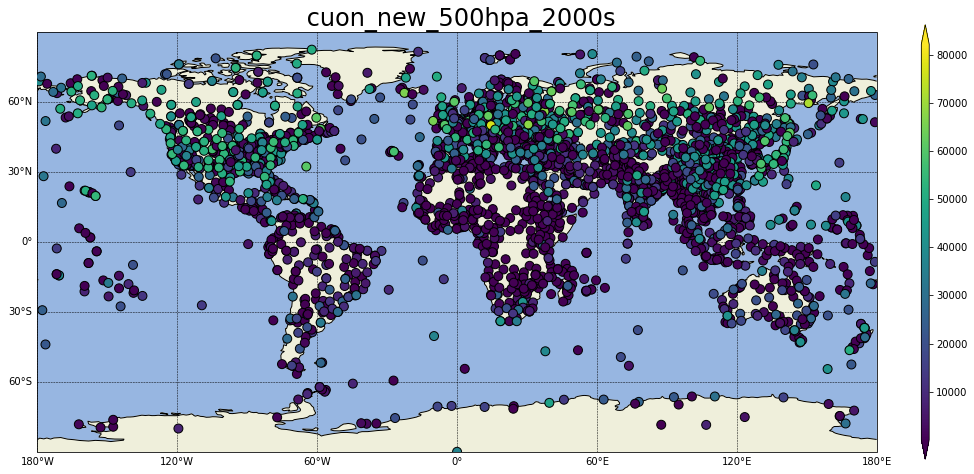

In [56]:
with open(c[3], 'rb') as handle:
    b = pickle.load(handle)
    print(c[3])
points(lon=b.lon, lat=b.lat, values=b.obs, showtitle=c[3].split('/')[-1][:-2])

<GeoAxesSubplot:title={'center':' cuon_new_500hpa_2000s -> 1 (yellow)\nigrah_500hpa_2000s -> 0 (purple)'}>

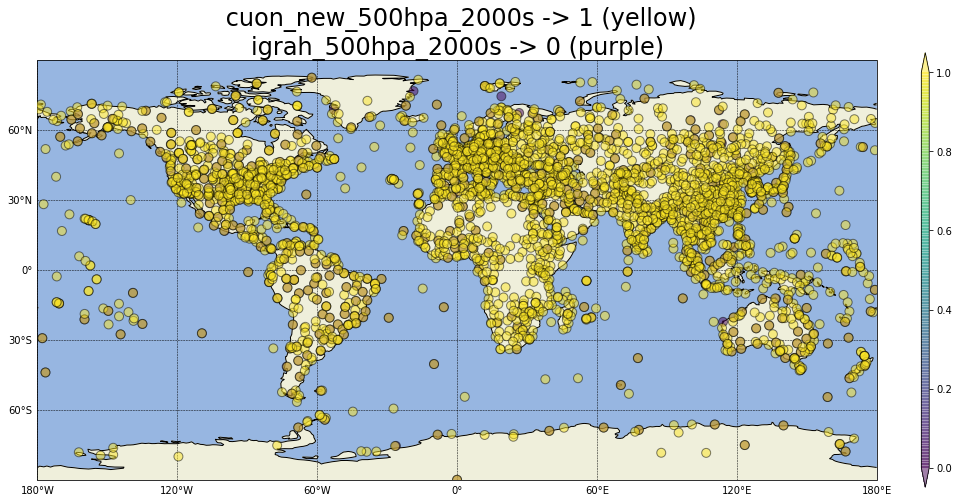

In [57]:
a['obs'].values[:] = 0
compare_i = a
b['obs'].values[:] = 1
compare_c = b
compare = pandas.DataFrame.append(compare_i, compare_c)
points(lon=compare.lon, lat=compare.lat, values=compare.obs, showalpha=0.5, showtitle=c[3].split('/')[-1][:-2] + ' -> 1 (yellow)'+ '\n' + i[3].split('/')[-1][:-2] +' -> 0 (purple)')

/raid60/scratch/uli/igrah_500hpa_2010s.p


<GeoAxesSubplot:title={'center':' igrah_500hpa_2010s'}>

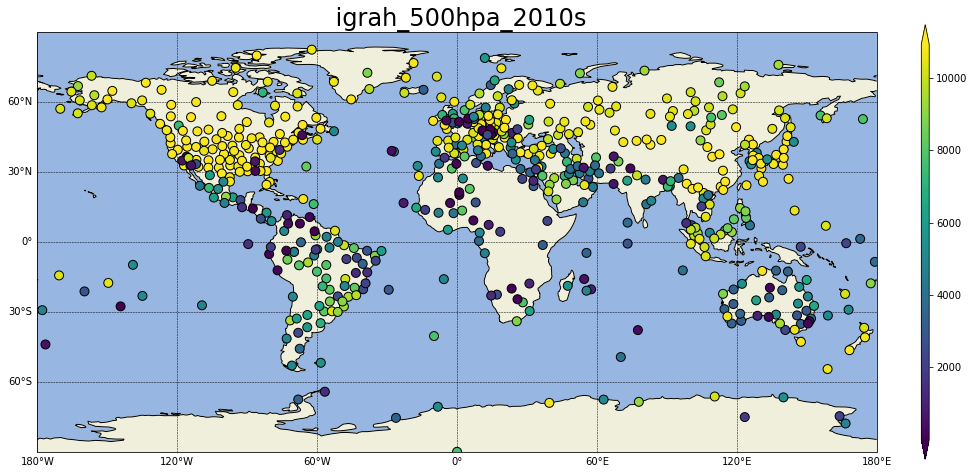

In [58]:
with open(i[2], 'rb') as handle:
    a = pickle.load(handle)
    print(i[2])
points(lon=a.lon, lat=a.lat, values=a.obs, showtitle=i[2].split('/')[-1][:-2])

/raid60/scratch/uli/cuon_new_500hpa_2010s.p


<GeoAxesSubplot:title={'center':' cuon_new_500hpa_2010s'}>

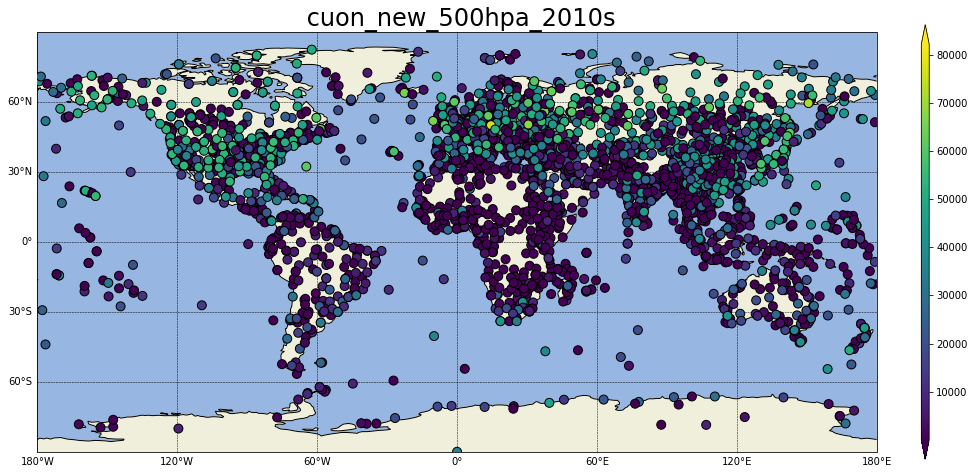

In [59]:
with open(c[0], 'rb') as handle:
    b = pickle.load(handle)
    print(c[0])
points(lon=b.lon, lat=b.lat, values=b.obs, showtitle=c[0].split('/')[-1][:-2])

<GeoAxesSubplot:title={'center':' cuon_new_500hpa_2010s -> 1 (yellow)\nigrah_500hpa_2010s -> 0 (purple)'}>

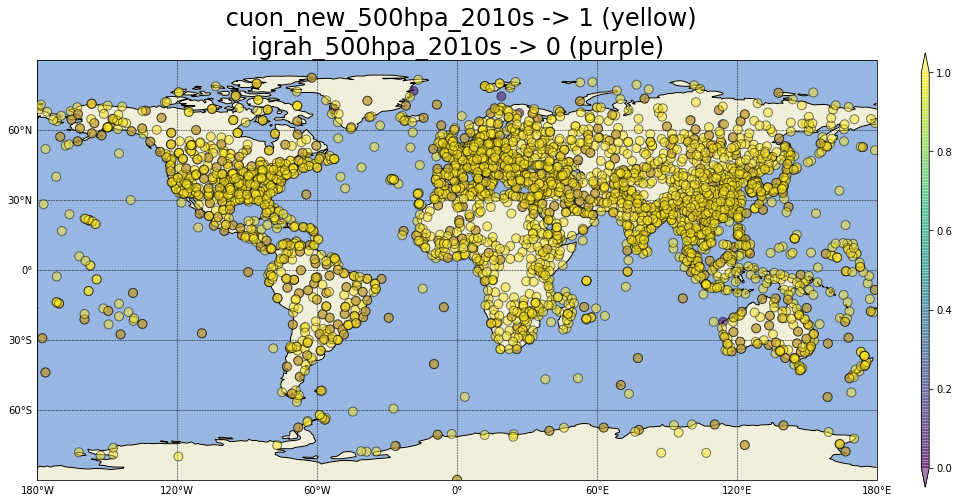

In [60]:
a['obs'].values[:] = 0
compare_i = a
b['obs'].values[:] = 1
compare_c = b
compare = pandas.DataFrame.append(compare_i, compare_c)
points(lon=compare.lon, lat=compare.lat, values=compare.obs, showalpha=0.5, showtitle=c[0].split('/')[-1][:-2] + ' -> 1 (yellow)'+ '\n' + i[2].split('/')[-1][:-2] +' -> 0 (purple)')